In [39]:
import os

if not os.path.exists("cnn-phone-classification"):
    !git clone https://github.com/sourav277/cnn-phone-classification.git


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os


In [41]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [42]:
train_data = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [43]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


In [44]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
train_loss, train_acc = [], []

for epoch in range(epochs):
    correct, total, running_loss = 0, 0, 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss)
    train_acc.append(correct / total)
    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}, Acc: {correct/total:.3f}")


Epoch 1, Loss: 455.833, Acc: 0.823
Epoch 2, Loss: 295.614, Acc: 0.885
Epoch 3, Loss: 253.140, Acc: 0.901
Epoch 4, Loss: 221.504, Acc: 0.912
Epoch 5, Loss: 197.084, Acc: 0.922


In [45]:
os.makedirs("model", exist_ok=True)


In [46]:
torch.save(model.state_dict(), "model/210141.pth")


In [60]:
import torch

torch.save(model.state_dict(), "210141.pth")


In [61]:
from google.colab import files
files.download("210141.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
model = CNN()
model.load_state_dict(torch.load("model/CNN.pth", map_location="cpu"))
model.eval()


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [49]:
valid_ext = ('.jpg', '.jpeg', '.png')

for img_name in os.listdir(image_dir):
    if not img_name.lower().endswith(valid_ext):
        continue   # skip .gitkeep or other files

    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path).convert("L")  # grayscale
    img = transform(img).unsqueeze(0)

    output = model(img)
    prob = torch.softmax(output, dim=1)
    confidence, pred = torch.max(prob, 1)

    print(f"{img_name} → Pred: {classes[pred]} ({confidence.item()*100:.2f}%)")


download (6).jpg → Pred: Trouser (83.18%)
download (1).jpg → Pred: Bag (57.18%)
download (2).jpg → Pred: Bag (68.48%)
download.jpg → Pred: Coat (37.64%)
download (3).jpg → Pred: Shirt (59.65%)
istockphoto-488160041-612x612.jpg → Pred: Trouser (28.16%)
download (4).jpg → Pred: Coat (35.31%)
download (5).jpg → Pred: Bag (33.70%)
download (7).jpg → Pred: Shirt (66.07%)
FSF-1170.jpg → Pred: Pullover (81.38%)


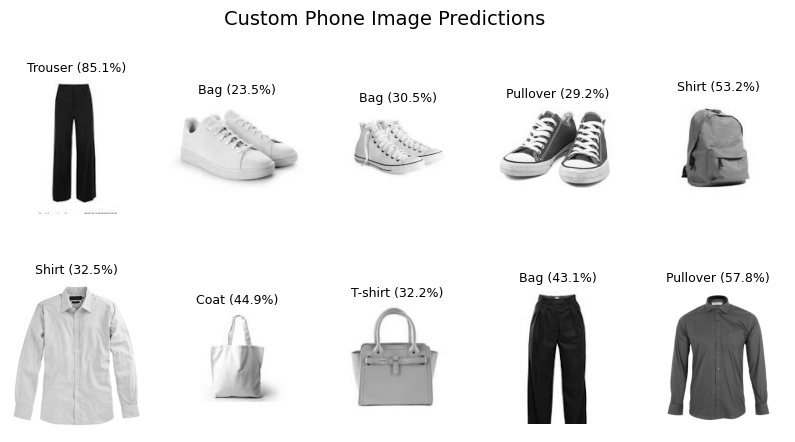

In [52]:
import matplotlib.pyplot as plt

valid_ext = ('.jpg', '.jpeg', '.png')
image_dir = "cnn-phone-classification/dataset"

model.eval()

images = []
titles = []

for img_name in os.listdir(image_dir):
    if not img_name.lower().endswith(valid_ext):
        continue

    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path).convert("L")
    img_t = transform(img).unsqueeze(0)

    with torch.no_grad():
        output = model(img_t)
        prob = torch.softmax(output, dim=1)
        conf, pred = torch.max(prob, 1)

    images.append(img)
    titles.append(f"{classes[pred]} ({conf.item()*100:.1f}%)")

# Plot grid
plt.figure(figsize=(10, 5))
for i in range(len(images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i], fontsize=9)
    plt.axis('off')

plt.suptitle("Custom Phone Image Predictions", fontsize=14)
plt.show()


In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


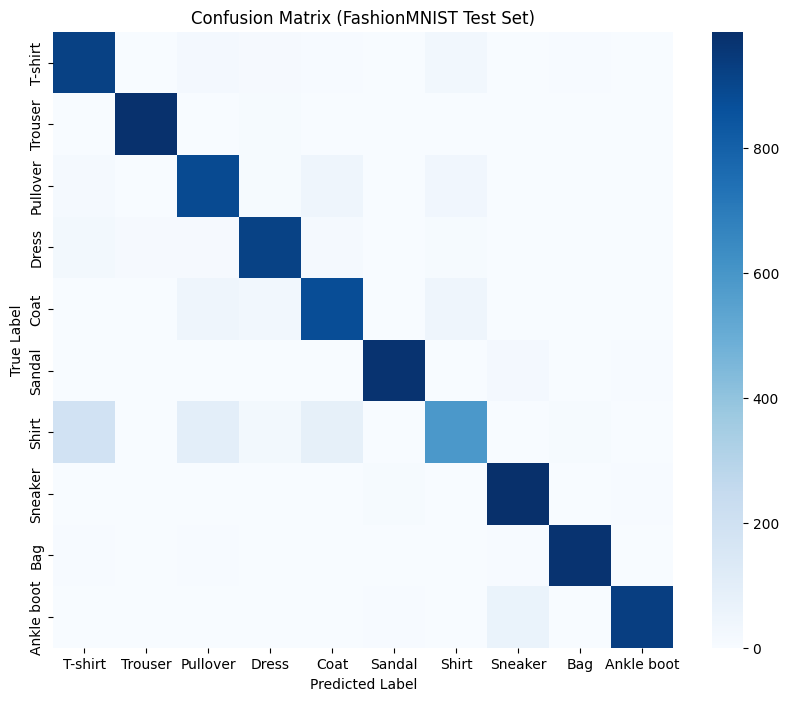

In [53]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (FashionMNIST Test Set)")
plt.show()


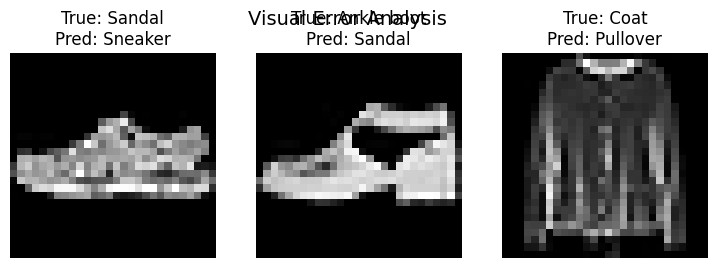

In [55]:
wrong_images = []
wrong_true = []
wrong_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            if preds[i] != labels[i]:
                wrong_images.append(images[i])
                wrong_true.append(labels[i])
                wrong_pred.append(preds[i])

            if len(wrong_images) == 3:
                break
        if len(wrong_images) == 3:
            break

plt.figure(figsize=(9, 3))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(wrong_images[i].squeeze(), cmap='gray')
    plt.title(f"True: {classes[wrong_true[i]]}\nPred: {classes[wrong_pred[i]]}")
    plt.axis('off')

plt.suptitle("Visual Error Analysis", fontsize=14)
plt.show()
